### Objective- Classification modelling Problem

1. Test, Train and Validation Split and Exploratory Data Analysis
2. Plotting stacked bar charts to club classes within a feature 
3. Converting classes into ordinal features.
4. Feature Selection using statistical testing, weight of evidence and entropy techniques ( chi-square test, spearman correlation, information value and mutual information criteria
5. Training base model using OLS Estimator and conducting model competition (statsmodel, pycaret)
6. Training LGBM which was the best model suggested by Pycaret and hypertuning the parameter to train a generalized model. (LGBM)
7. Finding Threshold for maximum auc using roc-auc.
8. Tuning model to give accuracy of 67% on train and validation set against an overfitted pycaret model with 71% accuracy.
9. Model Interpretation using Shap values

#### Importing Libraries and Data Extraction

In [143]:
## Importing the required packages/libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

In [144]:
## Data Extraction
coupon_df = pd.read_csv("in-vehicle-coupon-recommendation.csv")
coupon_df.head()

,destination,passanger,weather,temperature,time,coupon,expiration,gender,age,maritalStatus,...,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y
0,No Urgent Place,Alone,Sunny,55,2PM,Restaurant(<20),1d,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,0,0,0,1,1
1,No Urgent Place,Friend(s),Sunny,80,10AM,Coffee House,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,0,0,0,1,0
2,No Urgent Place,Friend(s),Sunny,80,10AM,Carry out & Take away,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,1
3,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,0
4,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,1d,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,0


In [145]:
coupon_df.shape

(12684, 26)

#### Exploratory Data Analysis

In [146]:
#Find out which columns have null values and total number of Nan values in that column
coupon_df.isna().sum()

destination                 0
passanger                   0
weather                     0
temperature                 0
time                        0
coupon                      0
expiration                  0
gender                      0
age                         0
maritalStatus               0
has_children                0
education                   0
occupation                  0
income                      0
car                     12576
Bar                       107
CoffeeHouse               217
CarryAway                 151
RestaurantLessThan20      130
Restaurant20To50          189
toCoupon_GEQ5min            0
toCoupon_GEQ15min           0
toCoupon_GEQ25min           0
direction_same              0
direction_opp               0
Y                           0
dtype: int64

In [147]:
# Determine percentage of missing data in a particular column for cleaning of the Data. 
# Columns in data with more than 95% null should be dropped. 
percent_missing =coupon_df.isnull().sum() * 100 / len(coupon_df)
percent_missing

destination              0.000000
passanger                0.000000
weather                  0.000000
temperature              0.000000
time                     0.000000
coupon                   0.000000
expiration               0.000000
gender                   0.000000
age                      0.000000
maritalStatus            0.000000
has_children             0.000000
education                0.000000
occupation               0.000000
income                   0.000000
car                     99.148534
Bar                      0.843582
CoffeeHouse              1.710817
CarryAway                1.190476
RestaurantLessThan20     1.024913
Restaurant20To50         1.490066
toCoupon_GEQ5min         0.000000
toCoupon_GEQ15min        0.000000
toCoupon_GEQ25min        0.000000
direction_same           0.000000
direction_opp            0.000000
Y                        0.000000
dtype: float64

In [148]:
list(percent_missing[percent_missing > 95].index)

['car']

In [149]:
#Dropping columns with percentage of missing values > 95% 
coupon_df.drop(columns=list(percent_missing[percent_missing > 95].index), inplace=True)

In [150]:
#DataFrame shape after dropping columns
coupon_df.shape

(12684, 25)

In [151]:
#Finding the value counts for columns with percent_missing between 0 and 95%
lst = list(percent_missing[(percent_missing > 0) & (percent_missing < 95)].index)
for i in lst:
    print(coupon_df[str(i)].value_counts())

never    5197
less1    3482
1~3      2473
4~8      1076
gt8       349
Name: Bar, dtype: int64
less1    3385
1~3      3225
never    2962
4~8      1784
gt8      1111
Name: CoffeeHouse, dtype: int64
1~3      4672
4~8      4258
less1    1856
gt8      1594
never     153
Name: CarryAway, dtype: int64
1~3      5376
4~8      3580
less1    2093
gt8      1285
never     220
Name: RestaurantLessThan20, dtype: int64
less1    6077
1~3      3290
never    2136
4~8       728
gt8       264
Name: Restaurant20To50, dtype: int64


In [152]:
#Replacing Nan values in each of these columns with most frequent value in that column.
for i in lst:
    coupon_df[i] = coupon_df[i].fillna(coupon_df[i].value_counts().index[0])
    print(coupon_df[i].isna().sum())

0
0
0
0
0


#### Test, Train and Validation Split

In [153]:
part_70 = coupon_df.sample(frac = 0.7)
test_df = coupon_df.drop(part_70.index)
print(test_df.shape, part_70.shape)


(3805, 25) (8879, 25)


In [154]:
validation_df = part_70.sample(frac = 0.3)
train_df = part_70.drop(validation_df.index)
train_df_wo_encoding=train_df 
validation_df_wo_encoding= validation_df
print(train_df.shape, validation_df.shape)

(6215, 25) (2664, 25)


#### Data Visualization: Stacked Bar charts

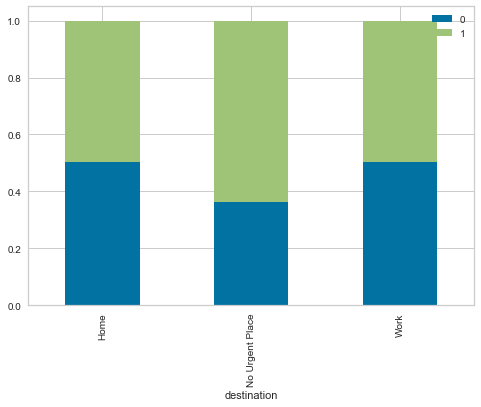

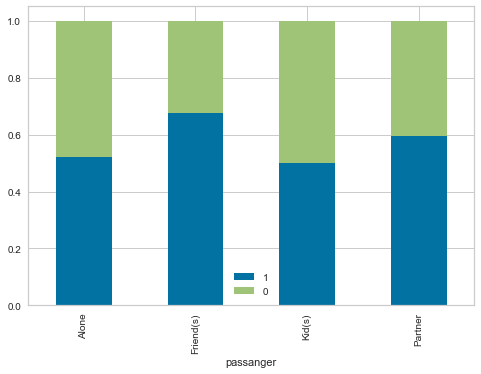

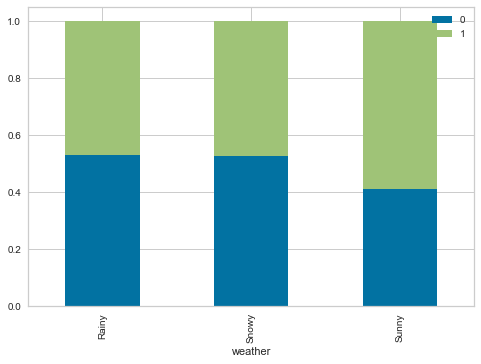

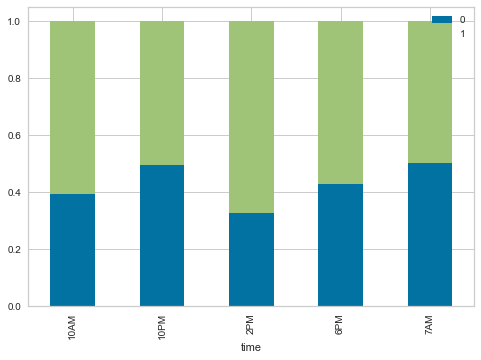

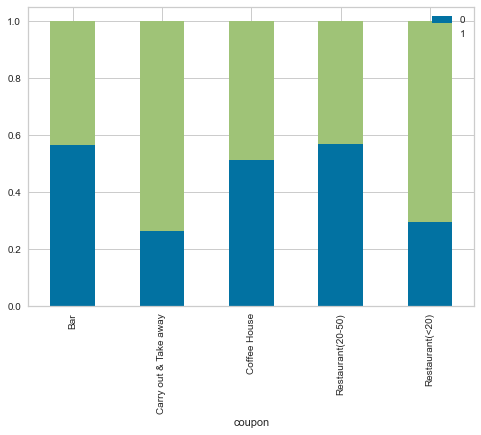

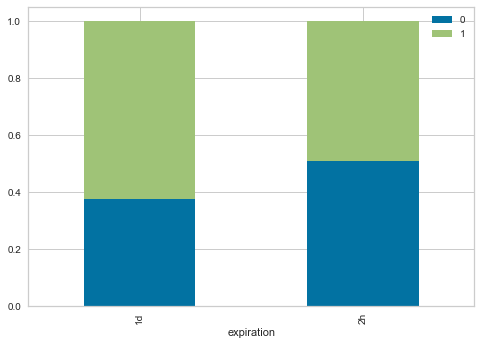

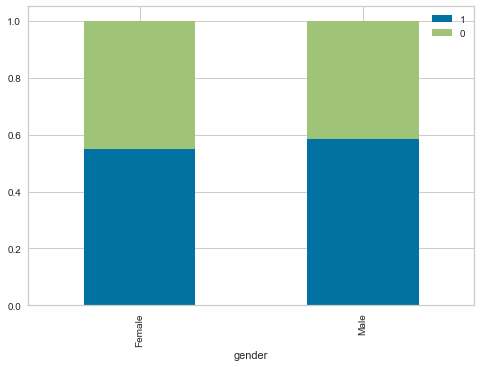

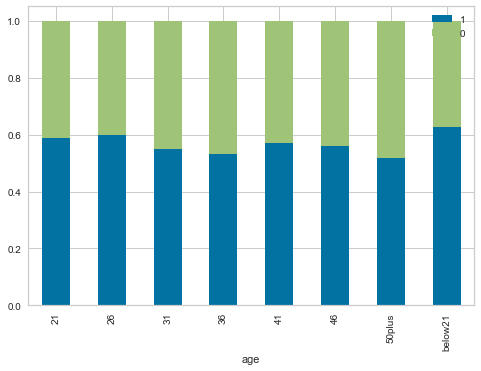

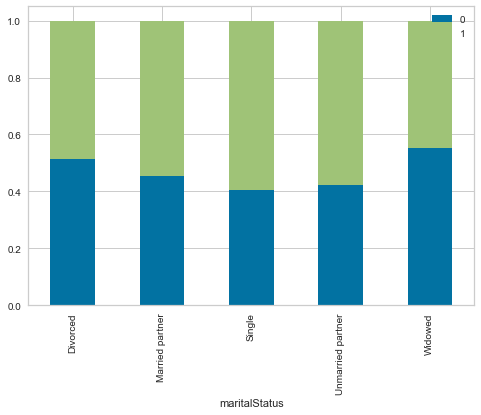

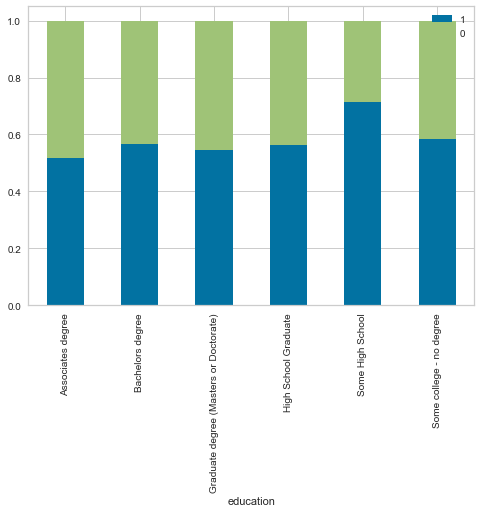

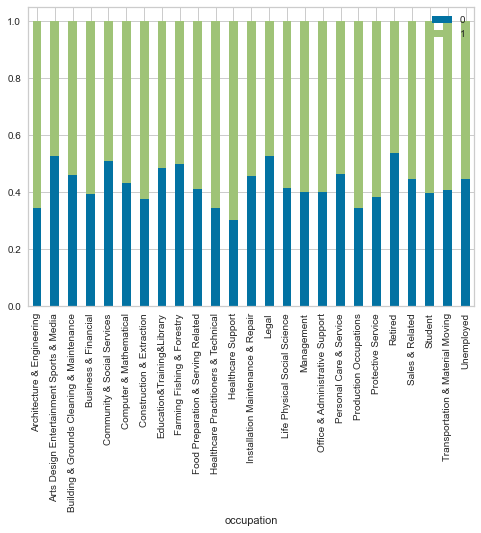

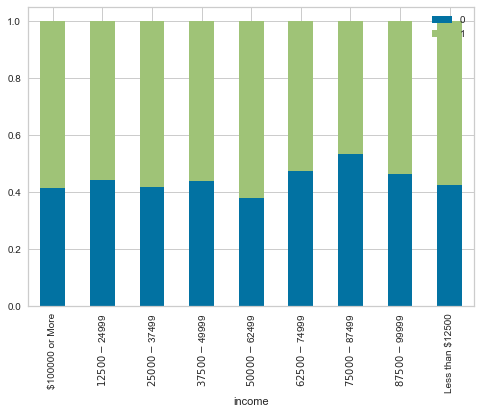

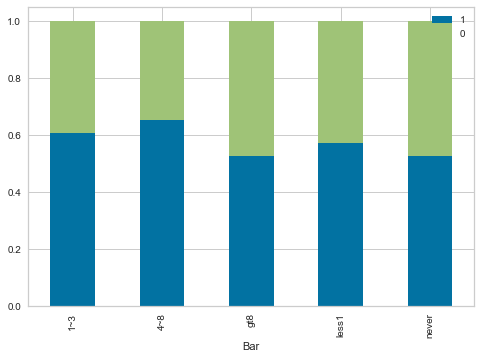

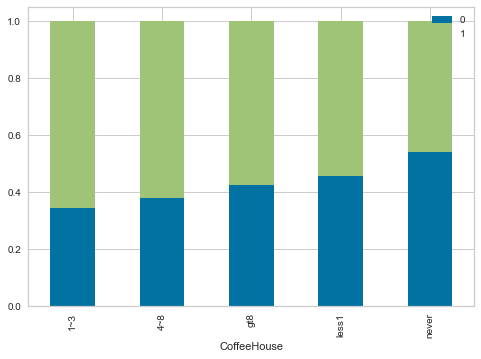

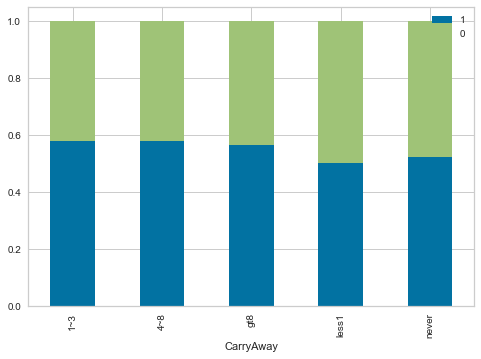

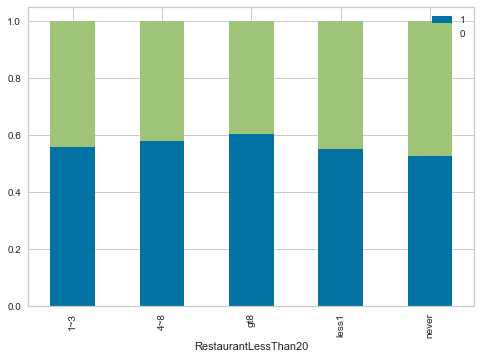

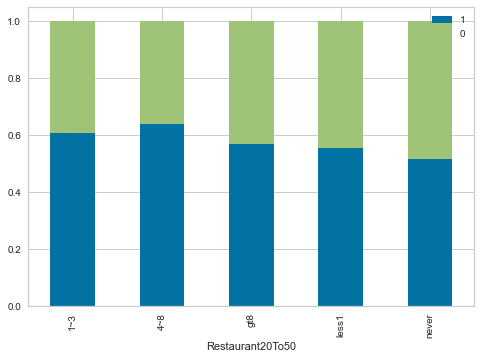

In [155]:
#Separate categorical and Numerical data 
# Plotting Stacked bar charts for columns with categorical data with values as percentage of each category in that column

categorical_data = train_df.select_dtypes(exclude=[np.number])
cat_list = list(categorical_data.columns)
numeric_data = train_df.select_dtypes(include=[np.number])
num_list = list(numeric_data.columns)

for i in cat_list:
    train_df.groupby([i])['Y'].apply(lambda x: x.value_counts() / len(x)).transpose().unstack().plot(kind='bar',stacked = True)


In [156]:
print(cat_list)

['destination', 'passanger', 'weather', 'time', 'coupon', 'expiration', 'gender', 'age', 'maritalStatus', 'education', 'occupation', 'income', 'Bar', 'CoffeeHouse', 'CarryAway', 'RestaurantLessThan20', 'Restaurant20To50']


### Clubbing Classes and converting them into Ordinal Features

In [157]:
## Using Stacked bar charts, categories with approx equal percentage are clubbed.
train_df['RestaurantLessThan20'] = train_df['RestaurantLessThan20'].replace(['1~3','4~8'],'1~8')
train_df['RestaurantLessThan20'].value_counts()

1~8      4487
less1    1025
gt8       595
never     108
Name: RestaurantLessThan20, dtype: int64

In [158]:
validation_df['RestaurantLessThan20'] = validation_df['RestaurantLessThan20'].replace(['1~3','4~8'],'1~8')

In [159]:
test_df['RestaurantLessThan20'] = test_df['RestaurantLessThan20'].replace(['1~3','4~8'],'1~8')

In [160]:
train_df['CarryAway'] = train_df['CarryAway'].replace(['1~3','4~8', 'gt8'],'1~8ngt8')
train_df['CarryAway'] = train_df['CarryAway'].replace(['less1','never'],'less1_never')
train_df['CarryAway'].value_counts()

1~8ngt8        5240
less1_never     975
Name: CarryAway, dtype: int64

In [161]:
validation_df['CarryAway'] = validation_df['CarryAway'].replace(['1~3','4~8', 'gt8'],'1~8ngt8')
validation_df['CarryAway'] = validation_df['CarryAway'].replace(['less1','never'],'less1_never')

In [162]:
test_df['CarryAway'] = test_df['CarryAway'].replace(['1~3','4~8', 'gt8'],'1~8ngt8')
test_df['CarryAway'] = test_df['CarryAway'].replace(['less1','never'],'less1_never')

In [163]:
train_df['CoffeeHouse'] = train_df['CoffeeHouse'].replace(['1~3','4~8', 'gt8'],'1~8ngt8')
train_df['CoffeeHouse'].value_counts()

1~8ngt8    3023
less1      1695
never      1497
Name: CoffeeHouse, dtype: int64

In [164]:
validation_df['CoffeeHouse'] = validation_df['CoffeeHouse'].replace(['1~3','4~8', 'gt8'],'1~8ngt8')

In [165]:
test_df['CoffeeHouse'] = test_df['CoffeeHouse'].replace(['1~3','4~8', 'gt8'],'1~8ngt8')

In [166]:
train_df['Bar'] = train_df['Bar'].replace(['1~3','4~8'],'1~8')
train_df['Bar'].value_counts()

never    2573
1~8      1764
less1    1699
gt8       179
Name: Bar, dtype: int64

In [167]:
validation_df['Bar'] = validation_df['Bar'].replace(['1~3','4~8'],'1~8')

In [168]:
test_df['Bar'] = test_df['Bar'].replace(['1~3','4~8'],'1~8')

In [169]:
train_df['income'] = train_df['income'].replace(['$12500 - $24999','$25000 - $37499','$37500 - $49999','$50000 - $62499'],'$12500-$62499')
train_df['income'] = train_df['income'].replace(['$75000 - $87499','$87500 - $99999','$62500 - $74999'],'$62499-$99999')
train_df['income'].value_counts()


$12500-$62499       3612
$62499-$99999       1265
$100000 or More      845
Less than $12500     493
Name: income, dtype: int64

In [170]:
validation_df['income'] = validation_df['income'].replace(['$12500 - $24999','$25000 - $37499','$37500 - $49999','$50000 - $62499'],'$12500-$62499')
validation_df['income'] = validation_df['income'].replace(['$75000 - $87499','$87500 - $99999','$62500 - $74999'],'$62499-$99999')

In [171]:
test_df['income'] = test_df['income'].replace(['$12500 - $24999','$25000 - $37499','$37500 - $49999','$50000 - $62499'],'$12500-$62499')
test_df['income'] = test_df['income'].replace(['$75000 - $87499','$87500 - $99999','$62500 - $74999'],'$62499-$99999')

In [172]:
l = ['Architecture & Engineering', 'Construction & Extraction','Healthcare Support','Food Preparation & Serving Related','Healthcare Practitioners & Technical', 'Farming Fishing & Forestry']
train_df['occupation'] = train_df['occupation'].replace(l,'Arch_cons_Health_Food_Farm')
train_df['occupation'] = train_df['occupation'].replace(['Business & Financial', 'Education&Training&Library', 'Retired'],'Buss_Edu_Retired')
train_df['occupation'] = train_df['occupation'].replace(['Arts Design Entertainment Sports & Media', 'Community & Social Services', 'Building & Grounds Cleaning & Maintenance'],'Arts_Comm_Building')
train_df['occupation'] = train_df['occupation'].replace(['Computer & Mathematical', 'Installation Maintenance & Repair', 'Personal Care & Service', 'Sales & Related', 'Unemployed'],'comp_Inst_Pers_Sales_Unemployed')
train_df['occupation'] = train_df['occupation'].replace(['Student', 'Management', 'Office & Administrative Support', 'Transportation & Material Moving', 'Protective Service','Life Physical Social Science', 'Production Occupations'],'Stud_manage_off_Trans_Protect_Life_Prod')
train_df['occupation'] = train_df['occupation'].replace(['Arts_Comm_Building','Buss_Edu_Retired'],'Arts_Comm_Building_Buss_Edu_Retired')
train_df['occupation'].value_counts()

comp_Inst_Pers_Sales_Unemployed            2291
Stud_manage_off_Trans_Protect_Life_Prod    1796
Arts_Comm_Building_Buss_Edu_Retired        1454
Arch_cons_Health_Food_Farm                  575
Legal                                        99
Name: occupation, dtype: int64

In [173]:
l = ['Architecture & Engineering', 'Construction & Extraction','Healthcare Support','Food Preparation & Serving Related','Healthcare Practitioners & Technical', 'Farming Fishing & Forestry']
validation_df['occupation'] = validation_df['occupation'].replace(l,'Arch_cons_Health_Food_Farm')
validation_df['occupation'] = validation_df['occupation'].replace(['Business & Financial', 'Education&Training&Library', 'Retired'],'Buss_Edu_Retired')
validation_df['occupation'] = validation_df['occupation'].replace(['Arts Design Entertainment Sports & Media', 'Community & Social Services', 'Building & Grounds Cleaning & Maintenance'],'Arts_Comm_Building')
validation_df['occupation'] = validation_df['occupation'].replace(['Computer & Mathematical', 'Installation Maintenance & Repair', 'Personal Care & Service', 'Sales & Related', 'Unemployed'],'comp_Inst_Pers_Sales_Unemployed')
validation_df['occupation'] = validation_df['occupation'].replace(['Student', 'Management', 'Office & Administrative Support', 'Transportation & Material Moving', 'Protective Service','Life Physical Social Science', 'Production Occupations'],'Stud_manage_off_Trans_Protect_Life_Prod')
validation_df['occupation'] = validation_df['occupation'].replace(['Arts_Comm_Building','Buss_Edu_Retired'],'Arts_Comm_Building_Buss_Edu_Retired')

In [174]:
l = ['Architecture & Engineering', 'Construction & Extraction','Healthcare Support','Food Preparation & Serving Related','Healthcare Practitioners & Technical', 'Farming Fishing & Forestry']
test_df['occupation'] = test_df['occupation'].replace(l,'Arch_cons_Health_Food_Farm')
test_df['occupation'] = test_df['occupation'].replace(['Business & Financial', 'Education&Training&Library', 'Retired'],'Buss_Edu_Retired')
test_df['occupation'] = test_df['occupation'].replace(['Arts Design Entertainment Sports & Media', 'Community & Social Services', 'Building & Grounds Cleaning & Maintenance'],'Arts_Comm_Building')
test_df['occupation'] = test_df['occupation'].replace(['Computer & Mathematical', 'Installation Maintenance & Repair', 'Personal Care & Service', 'Sales & Related', 'Unemployed'],'comp_Inst_Pers_Sales_Unemployed')
test_df['occupation'] = test_df['occupation'].replace(['Student', 'Management', 'Office & Administrative Support', 'Transportation & Material Moving', 'Protective Service','Life Physical Social Science', 'Production Occupations'],'Stud_manage_off_Trans_Protect_Life_Prod')
test_df['occupation'] = test_df['occupation'].replace(['Arts_Comm_Building','Buss_Edu_Retired'],'Arts_Comm_Building_Buss_Edu_Retired')

In [175]:
train_df['education'] = train_df['education'].replace(['Bachelors degree','Associates degree', 'Graduate degree (Masters or Doctorate)'],'Bach_Mast_Asso')
train_df['education'] = train_df['education'].replace(['Some college - no degree','High School Graduate'],'Nodeg_HSGrad')
train_df['education'].value_counts()

Bach_Mast_Asso      3567
Nodeg_HSGrad        2599
Some High School      49
Name: education, dtype: int64

In [176]:
validation_df['education'] = validation_df['education'].replace(['Bachelors degree','Associates degree', 'Graduate degree (Masters or Doctorate)'],'Bach_Mast_Asso')
validation_df['education'] = validation_df['education'].replace(['Some college - no degree','High School Graduate'],'Nodeg_HSGrad')

In [177]:
test_df['education'] = test_df['education'].replace(['Bachelors degree','Associates degree', 'Graduate degree (Masters or Doctorate)'],'Bach_Mast_Asso')
test_df['education'] = test_df['education'].replace(['Some college - no degree','High School Graduate'],'Nodeg_HSGrad')

In [178]:
train_df['maritalStatus'] = train_df['maritalStatus'].replace(['Married partner', 'Divorced', 'Widowed'],'Married_Divorced_Widowed')
train_df['maritalStatus'] = train_df['maritalStatus'].replace(['Single', 'Unmarried partner'],'Single_Unmarriedpartner')
train_df['maritalStatus'].value_counts()

Single_Unmarriedpartner     3366
Married_Divorced_Widowed    2849
Name: maritalStatus, dtype: int64

In [179]:
validation_df['maritalStatus'] = validation_df['maritalStatus'].replace(['Married partner', 'Divorced', 'Widowed'],'Married_Divorced_Widowed')
validation_df['maritalStatus'] = validation_df['maritalStatus'].replace(['Single', 'Unmarried partner'],'Single_Unmarriedpartner')

In [180]:
test_df['maritalStatus'] = test_df['maritalStatus'].replace(['Married partner', 'Divorced', 'Widowed'],'Married_Divorced_Widowed')
test_df['maritalStatus'] = test_df['maritalStatus'].replace(['Single', 'Unmarried partner'],'Single_Unmarriedpartner')

In [181]:
train_df['age'] = train_df['age'].replace(['26','21', 'below21'],'below26')
train_df['age'] = train_df['age'].replace(['31','50plus', '36','41', '46'],'above26')
train_df['age'].value_counts()

above26    3429
below26    2786
Name: age, dtype: int64

In [182]:
validation_df['age'] = validation_df['age'].replace(['26','21', 'below21'],'below26')
validation_df['age'] = validation_df['age'].replace(['31','50plus', '36','41', '46'],'above26')

In [183]:
test_df['age'] = test_df['age'].replace(['26','21', 'below21'],'below26')
test_df['age'] = test_df['age'].replace(['31','50plus', '36','41', '46'],'above26')

In [184]:
train_df['coupon'] = train_df['coupon'].replace(['Restaurant(20-50)','Bar'],'Rest(20-50)_n_Bar')
train_df['coupon'] = train_df['coupon'].replace(['Restaurant(<20)','Coffee House','Carry out & Take away'],'Rest(<20)_CH_CT')
train_df['coupon'].value_counts()

Rest(<20)_CH_CT      4498
Rest(20-50)_n_Bar    1717
Name: coupon, dtype: int64

In [185]:
validation_df['coupon'] = validation_df['coupon'].replace(['Restaurant(20-50)','Bar'],'Rest(20-50)_n_Bar')
validation_df['coupon'] = validation_df['coupon'].replace(['Restaurant(<20)','Coffee House','Carry out & Take away'],'Rest(<20)_CH_CT')

In [186]:
test_df['coupon'] = test_df['coupon'].replace(['Restaurant(20-50)','Bar'],'Rest(20-50)_n_Bar')
test_df['coupon'] = test_df['coupon'].replace(['Restaurant(<20)','Coffee House','Carry out & Take away'],'Rest(<20)_CH_CT')

In [187]:
train_df['destination'] = train_df['destination'].replace(['Home','Work'],'Home_n_Work')
train_df['destination'].value_counts()


Home_n_Work        3122
No Urgent Place    3093
Name: destination, dtype: int64

In [188]:
validation_df['destination'] = validation_df['destination'].replace(['Home','Work'],'Home_n_Work')

In [189]:
test_df['destination'] = test_df['destination'].replace(['Home','Work'],'Home_n_Work')

In [190]:
train_df['passanger'] = train_df['passanger'].replace(['Alone','Kid(s)'],'Alone_n_Kids')
train_df['passanger'].value_counts()

Alone_n_Kids    4041
Friend(s)       1636
Partner          538
Name: passanger, dtype: int64

In [191]:
validation_df['passanger'] = validation_df['passanger'].replace(['Alone','Kid(s)'],'Alone_n_Kids')

In [192]:
test_df['passanger'] = test_df['passanger'].replace(['Alone','Kid(s)'],'Alone_n_Kids')

In [193]:
train_df['weather'] = train_df['weather'].replace(['Snowy','Rainy'],'Snowy_n_Rainy')
train_df['weather'].value_counts()

Sunny            4927
Snowy_n_Rainy    1288
Name: weather, dtype: int64

In [194]:
validation_df['weather'] = validation_df['weather'].replace(['Snowy','Rainy'],'Snowy_n_Rainy')

In [195]:
test_df['weather'] = test_df['weather'].replace(['Snowy','Rainy'],'Snowy_n_Rainy')

In [196]:
train_df['time'] = train_df['time'].replace(['7AM','10PM'],'7AM_n_10PM')
train_df['time'] = train_df['time'].replace(['6PM','10AM', '2PM'],'6PM_10AM_2PM')
train_df['time'].value_counts()

6PM_10AM_2PM    3701
7AM_n_10PM      2514
Name: time, dtype: int64

In [197]:
validation_df['time'] = validation_df['time'].replace(['7AM','10PM'],'7AM_n_10PM')
validation_df['time'] = validation_df['time'].replace(['6PM','10AM', '2PM'],'6PM_10AM_2PM')

In [198]:
test_df['time'] = test_df['time'].replace(['7AM','10PM'],'7AM_n_10PM')
test_df['time'] = test_df['time'].replace(['6PM','10AM', '2PM'],'6PM_10AM_2PM')

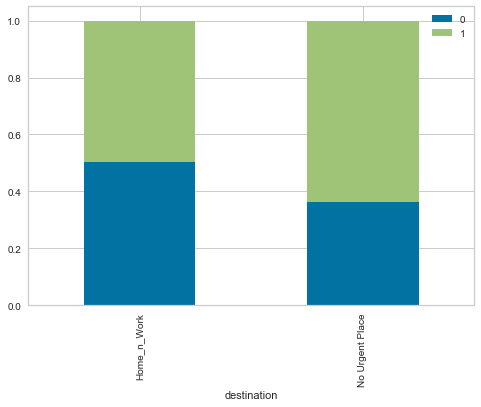

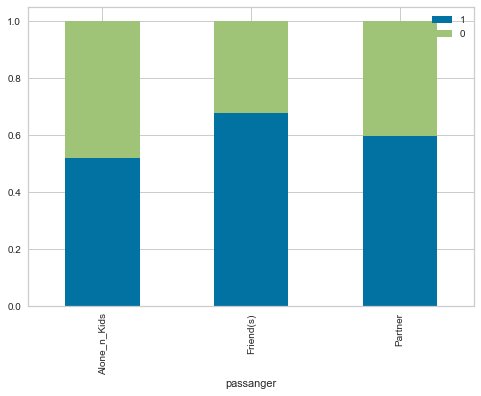

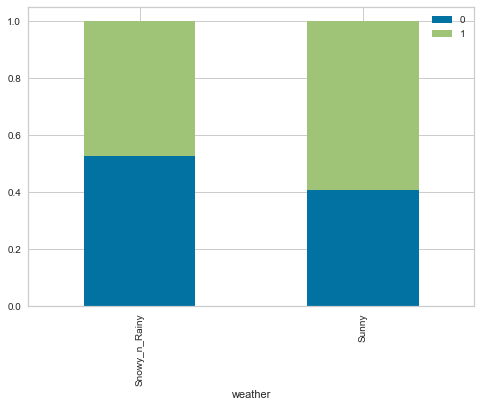

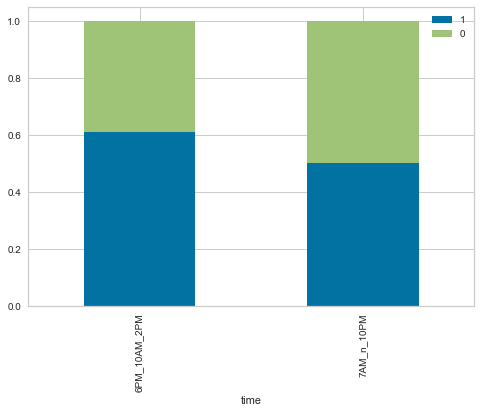

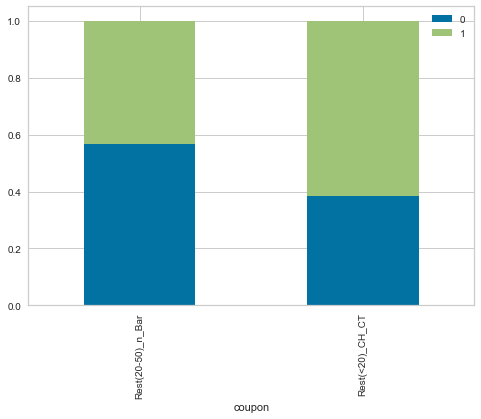

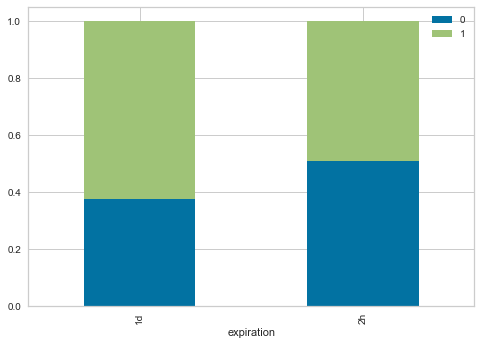

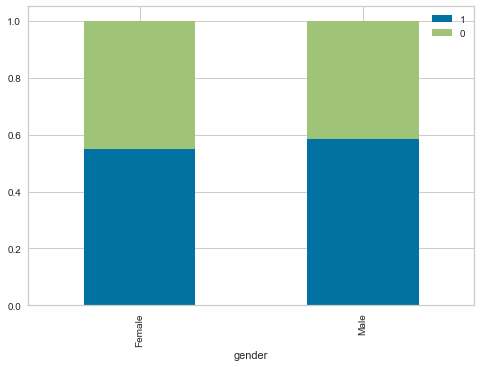

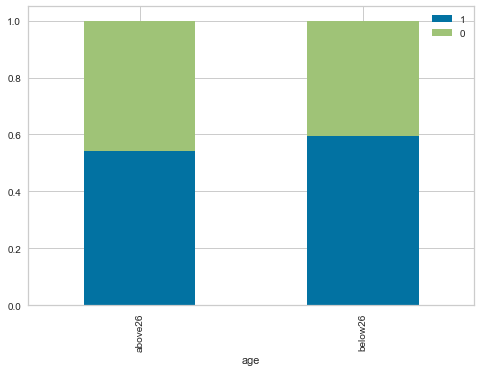

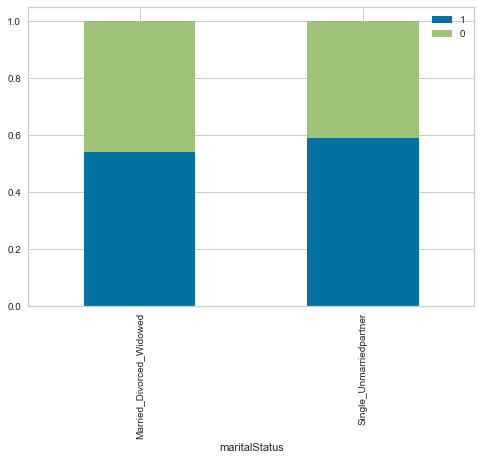

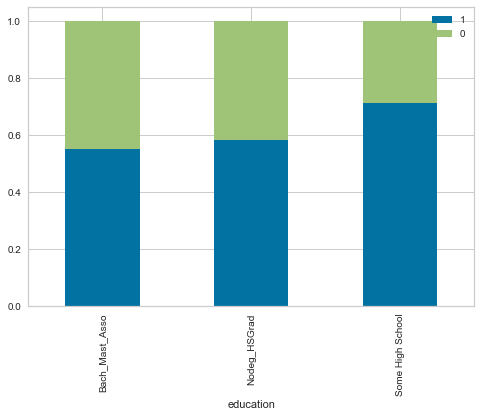

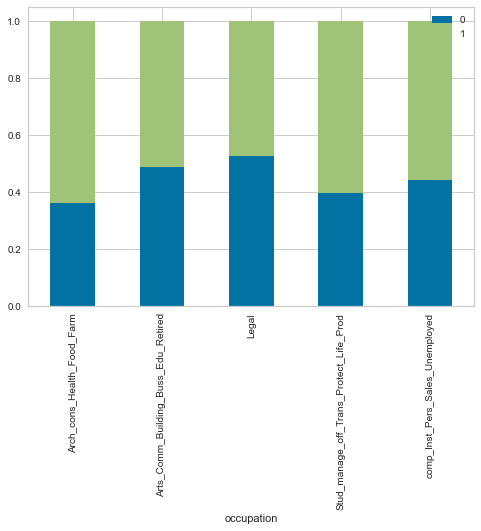

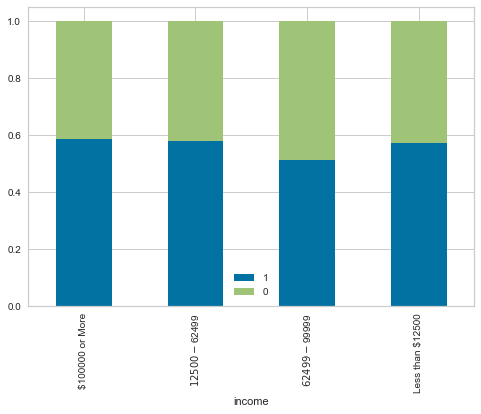

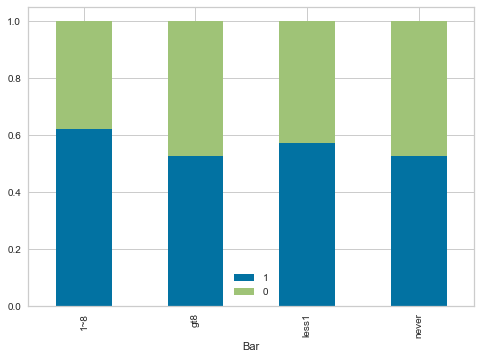

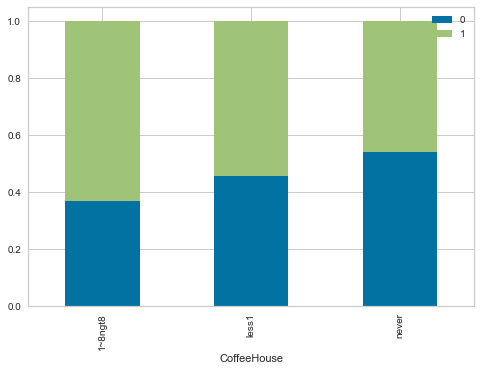

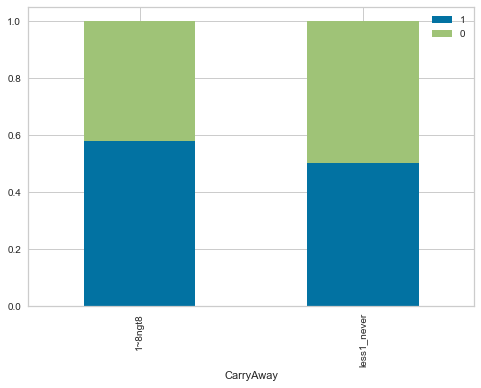

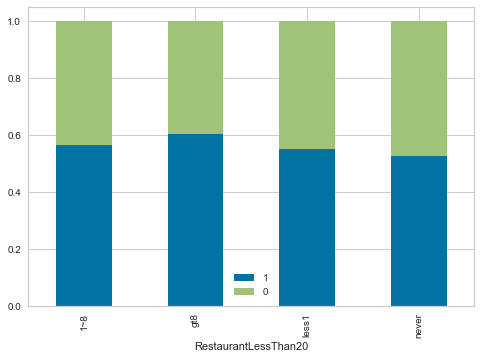

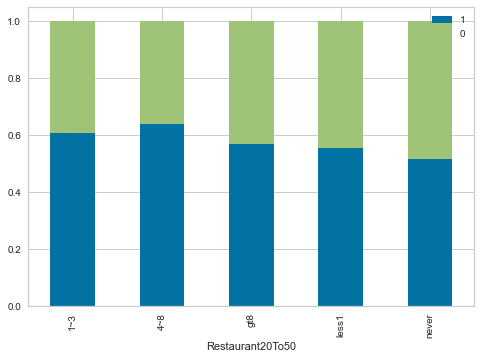

In [199]:
for i in cat_list:
    train_df.groupby([i])['Y'].apply(lambda x: x.value_counts() / len(x)).transpose().unstack().plot(kind='bar',stacked = True)

In [200]:
#train_df.groupby(['Restaurant20To50'])['Y'].apply(lambda x: x.value_counts() / len(x))

In [201]:
#cat_list

### Encoding for classes to make them ordinal

In [202]:
cleanup_nums = {"destination": {"No Urgent Place": 2,"Home_n_Work": 1 },
                "passanger":   {"Alone_n_Kids": 3, "Partner": 2, "Friend(s)": 1},
                "weather": {"Sunny": 2,"Snowy_n_Rainy": 1},
                "time": {"6PM_10AM_2PM": 2,"7AM_n_10PM": 1},
                "coupon": {"Rest(<20)_CH_CT": 2,"Rest(20-50)_n_Bar": 1},
                "expiration": {"1d": 2,"2h": 1},
                "gender": {"Male": 2,"Female": 1},
                "age": {"below26": 2,"above26": 1},
                "maritalStatus": {"Single_Unmarriedpartner": 2,"Married_Divorced_Widowed": 1},
                "education": {"Some High School": 3,"Nodeg_HSGrad": 2, "Bach_Mast_Asso": 1 },
                "occupation": {"Arch_cons_Health_Food_Farm": 5,"Stud_manage_off_Trans_Protect_Life_Prod": 4,"comp_Inst_Pers_Sales_Unemployed": 3, "Arts_Comm_Building_Buss_Edu_Retired": 2, "Legal": 1 },
                "income": {"Less than $12500": 4,"$12500-$62499": 3,"$100000 or More": 2, "$62499-$99999": 1},
                "car": {"Car that is too old _n_Mazda5": 4,"Scooter and motorcycle": 3, "do not drive": 2, "crossover": 1 },
                "Bar": {"1~8": 4,"less1": 3, "gt8": 2, "never": 1 },
                "CoffeeHouse": {"1~8ngt8": 3, "less1": 2, "never": 1 },
                "CarryAway": {"1~8ngt8": 2, "less1_never": 1 },
                "RestaurantLessThan20": {"gt8": 4,"1~8": 3, "never": 2, "less1": 1 },
                "Restaurant20To50": {"gt8": 5, "4~8": 4,"1~3": 3, "less1": 2, "never": 1 }
                }
train_df = train_df.replace(cleanup_nums)

In [203]:
validation_df = validation_df.replace(cleanup_nums)

In [204]:
test_df = test_df.replace(cleanup_nums)

In [205]:
train_df.head()

,destination,passanger,weather,temperature,time,coupon,expiration,gender,age,maritalStatus,...,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y
2901,2,1,2,80,2,2,2,2,2,2,...,3,2,3,2,1,1,0,0,1,1
6909,2,3,2,80,2,2,2,2,1,2,...,3,2,3,2,1,1,0,0,1,1
5521,1,3,2,55,1,2,2,2,2,2,...,2,2,1,1,1,1,0,0,1,0
10742,2,1,2,30,1,2,2,1,1,1,...,3,2,3,4,1,1,0,0,1,1
10259,1,3,2,80,2,1,1,1,1,1,...,3,2,3,2,1,1,0,1,0,0


In [206]:
num_list

['temperature',
 'has_children',
 'toCoupon_GEQ5min',
 'toCoupon_GEQ15min',
 'toCoupon_GEQ25min',
 'direction_same',
 'direction_opp',
 'Y']

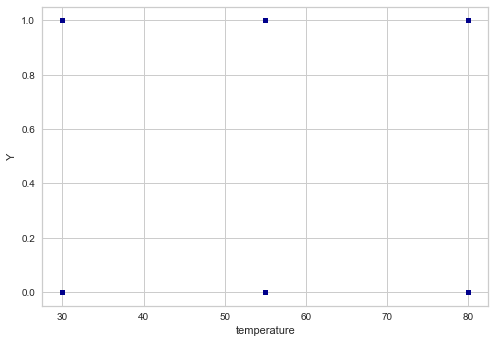

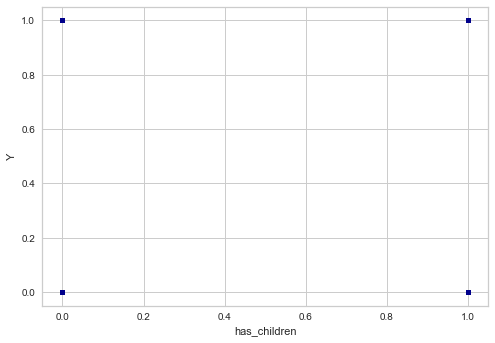

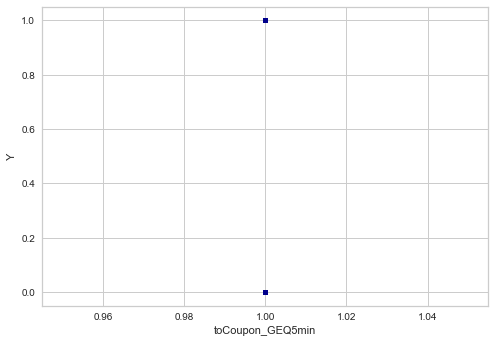

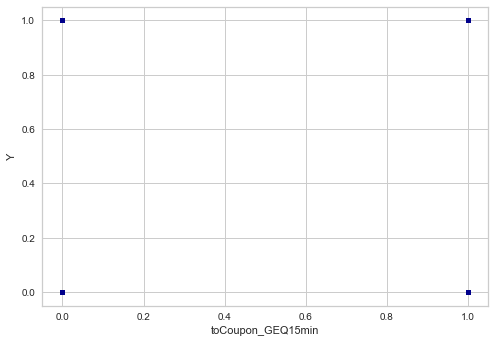

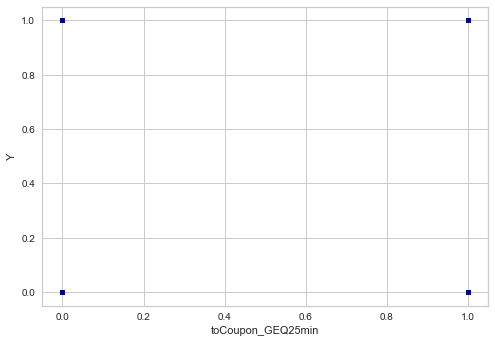

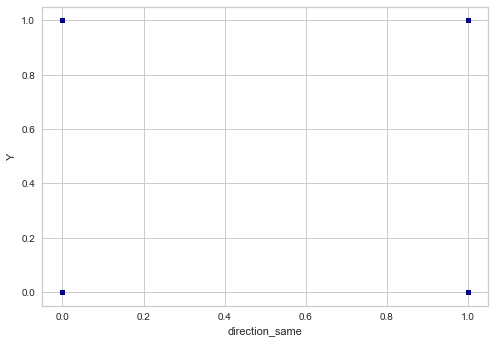

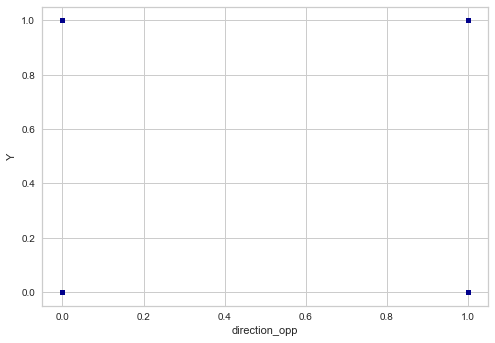

In [207]:
num_list_new = num_list[0:7]
for i in num_list_new:
    ax1 =train_df.plot.scatter(x=i, y='Y',c='DarkBlue')

#### Feature Selection
##### Spearman correlation

In [208]:
my_r = train_df.corr(method="spearman")['Y']
print(my_r)

destination             0.139735
passanger              -0.139902
weather                 0.097773
temperature             0.054965
time                    0.107852
coupon                  0.166195
expiration              0.134677
gender                  0.037045
age                     0.053520
maritalStatus           0.051913
has_children           -0.038072
education               0.033266
occupation              0.084417
income                  0.039724
Bar                     0.076598
CoffeeHouse             0.142091
CarryAway               0.056147
RestaurantLessThan20    0.025844
Restaurant20To50        0.066700
toCoupon_GEQ5min             NaN
toCoupon_GEQ15min      -0.075120
toCoupon_GEQ25min      -0.086965
direction_same          0.008624
direction_opp          -0.008624
Y                       1.000000
Name: Y, dtype: float64


##### Chi-square Test

In [209]:
from sklearn.feature_selection import chi2
import numpy as np
for i in train_df.columns:
    X = np.array(train_df[i]).reshape(-1,1)
    y = train_df['Y']
    chi_scores = chi2(X,y)
    #print(chi_scores[0][0])
    print(chi_scores[1][0])
    
#for i in chisq:
    #print(i[0])
    


6.772230687192022e-06
3.2957659654583797e-10
0.019627470698028025
1.0464187296985013e-22
0.0009540991811707112
8.10895812302843e-06
2.291826514421476e-05
0.2314605037850442
0.08123230045579588
0.10050988600734079
0.02181770106797386
0.2366971445285389
0.00038339206780538086
0.04566495667361888
9.237938604027855e-07
8.513229656594046e-10
0.2357175216340463
0.3645391256175614
0.004473505684935964
1.0
8.369234694889688e-05
1.198687644534179e-10
0.5471305390068573
0.7521525288066637
0.0


In [210]:
# for i in num_list:
#     X = np.array(train_df[i]).reshape(-1,1)
#     y = train_df['Y']
#     chi_scores = chi2(X,y)
#     print(i, chi_scores)


In [211]:
train_df['toCoupon_GEQ5min'].dtypes

dtype('int64')

In [212]:
train_df['toCoupon_GEQ5min'].value_counts()

1    6215
Name: toCoupon_GEQ5min, dtype: int64

In [213]:
train_df['toCoupon_GEQ15min'].dtypes

dtype('int64')

In [214]:
train_df['toCoupon_GEQ15min'].value_counts()

1    3473
0    2742
Name: toCoupon_GEQ15min, dtype: int64

In [215]:
train_df

,destination,passanger,weather,temperature,time,coupon,expiration,gender,age,maritalStatus,...,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y
2901,2,1,2,80,2,2,2,2,2,2,...,3,2,3,2,1,1,0,0,1,1
6909,2,3,2,80,2,2,2,2,1,2,...,3,2,3,2,1,1,0,0,1,1
5521,1,3,2,55,1,2,2,2,2,2,...,2,2,1,1,1,1,0,0,1,0
10742,2,1,2,30,1,2,2,1,1,1,...,3,2,3,4,1,1,0,0,1,1
10259,1,3,2,80,2,1,1,1,1,1,...,3,2,3,2,1,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9669,2,1,1,55,1,1,1,2,2,2,...,1,2,3,3,1,1,0,0,1,1
2410,2,1,2,80,2,1,2,1,2,2,...,3,2,3,2,1,0,0,0,1,0
969,2,1,2,80,2,2,1,1,1,1,...,2,2,3,2,1,0,0,0,1,1
3079,2,1,2,80,2,2,1,2,2,2,...,3,2,4,5,1,1,0,0,1,0


In [216]:
Ytrain = train_df['Y']
Xtrain = train_df.drop(['Y'], axis=1)
print(Xtrain)

       destination  passanger  weather  temperature  time  coupon  expiration  \
2901             2          1        2           80     2       2           2   
6909             2          3        2           80     2       2           2   
5521             1          3        2           55     1       2           2   
10742            2          1        2           30     1       2           2   
10259            1          3        2           80     2       1           1   
...            ...        ...      ...          ...   ...     ...         ...   
9669             2          1        1           55     1       1           1   
2410             2          1        2           80     2       1           2   
969              2          1        2           80     2       2           1   
3079             2          1        2           80     2       2           1   
1208             1          3        2           80     2       2           1   

       gender  age  marital

##### Mutual Information

In [217]:
from sklearn.feature_selection import mutual_info_classif
mutual_info = mutual_info_classif(Xtrain, Ytrain)
mutual_info

array([0.00469865, 0.01677571, 0.00394657, 0.        , 0.00728958,
       0.02595773, 0.00718457, 0.        , 0.        , 0.0042724 ,
       0.        , 0.        , 0.00617954, 0.00491289, 0.00727751,
       0.00677667, 0.00178981, 0.00533175, 0.        , 0.        ,
       0.        , 0.00738604, 0.0035103 , 0.00757602])

In [218]:
mutual_info = pd.Series(mutual_info)
mutual_info.index = Xtrain.columns
mutual_info.sort_values(ascending=False)

coupon                  0.025958
passanger               0.016776
direction_opp           0.007576
toCoupon_GEQ25min       0.007386
time                    0.007290
Bar                     0.007278
expiration              0.007185
CoffeeHouse             0.006777
occupation              0.006180
RestaurantLessThan20    0.005332
income                  0.004913
destination             0.004699
maritalStatus           0.004272
weather                 0.003947
direction_same          0.003510
CarryAway               0.001790
has_children            0.000000
age                     0.000000
gender                  0.000000
Restaurant20To50        0.000000
toCoupon_GEQ5min        0.000000
temperature             0.000000
toCoupon_GEQ15min       0.000000
education               0.000000
dtype: float64

In [219]:
#Finding 5 best features using SelectKBest of Sklearn.feature_selection
from sklearn.feature_selection import SelectKBest
sel_five_cols = SelectKBest(mutual_info_classif, k=5)
sel_five_cols.fit(Xtrain, Ytrain)
Xtrain.columns[sel_five_cols.get_support()]

Index(['destination', 'coupon', 'CoffeeHouse', 'RestaurantLessThan20',
       'toCoupon_GEQ15min'],
      dtype='object')

In [220]:

sel_ten_cols = SelectKBest(mutual_info_classif, k=10)
sel_ten_cols.fit(Xtrain, Ytrain)
Xtrain.columns[sel_ten_cols.get_support()]

Index(['destination', 'weather', 'temperature', 'time', 'coupon', 'education',
       'occupation', 'CoffeeHouse', 'toCoupon_GEQ5min', 'toCoupon_GEQ25min'],
      dtype='object')

In [221]:
Ytrain.value_counts()

1    3518
0    2697
Name: Y, dtype: int64

##### Weight of Evidence and Information value

In [222]:
df_woe_iv = (pd.crosstab(Xtrain['destination'],Ytrain,
                      normalize='columns')
             .assign(woe=lambda dfx: np.log(dfx[1] / dfx[0]))
             .assign(iv=lambda dfx: np.sum(dfx['woe']*
                                           (dfx[1]-dfx[0]))))
df_woe_iv.iv.sum()

0.16013264565206065

In [223]:
for i in Xtrain.columns:
    l =[]
    df_woe_iv = (pd.crosstab(Xtrain[i],Ytrain,
                      normalize='columns')
             .assign(woe=lambda dfx: np.log(dfx[1] / dfx[0]))
             .assign(iv=lambda dfx: np.sum(dfx['woe']*
                                         (dfx[1]-dfx[0]))))
    print(df_woe_iv)
    l.append(df_woe_iv.iv.sum()) 
    print(l)
    

Y                   0        1       woe        iv
destination                                       
1            0.582128  0.44116 -0.277284  0.080066
2            0.417872  0.55884  0.290689  0.080066
[0.16013264565206065]
Y                 0         1       woe        iv
passanger                                        
1          0.195773  0.314952  0.475463  0.083326
2          0.080831  0.090961  0.118073  0.083326
3          0.723396  0.594088 -0.196931  0.083326
[0.2499779459398187]
Y               0         1       woe        iv
weather                                        
1        0.252503  0.172541 -0.380786  0.038575
2        0.747497  0.827459  0.101629  0.038575
[0.07714928880820504]
Y                   0         1       woe        iv
temperature                                        
30           0.193919  0.172825 -0.115159  0.013848
55           0.325918  0.288232 -0.122879  0.013848
80           0.480163  0.538943  0.115483  0.013848
[0.04154388836094304]
Y      

#### Modelling using Linear Regression model and finding best features

In [224]:
##Finding Best features using Backward Algorithm with Linear Regression
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from sklearn.linear_model import LinearRegression
lreg = LinearRegression()

sfs1 = sfs(lreg, k_features=10, forward=False, verbose=2, scoring='neg_mean_squared_error')
sfs1 = sfs1.fit(Xtrain, Ytrain)
feat_names = list(sfs1.k_feature_names_)
print(feat_names)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    0.9s finished

[2022-01-27 13:59:51] Features: 23/10 -- score: -0.21670215446388083[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed:    0.6s finished

[2022-01-27 13:59:52] Features: 22/10 -- score: -0.21665165330209818[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    0.5s finished

[2022-01-27 13:59:52] Features: 21/10 -- score: -0.21660726924102836[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)

['destination', 'passanger', 'weather', 'coupon', 'expiration', 'occupation', 'income', 'Bar', 'CoffeeHouse', 'direction_same']


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.1s finished

[2022-01-27 13:59:56] Features: 11/10 -- score: -0.21677868917283996[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    0.1s finished

[2022-01-27 13:59:56] Features: 10/10 -- score: -0.2170360739584117

In [225]:
##Finding Best features using Forward Algorithm with Linear Regression
lreg = LinearRegression()
sfs2 = sfs(lreg, k_features=10, forward=True, verbose=2, scoring='neg_mean_squared_error')
sfs2 = sfs2.fit(Xtrain, Ytrain)
feat_names2 = list(sfs2.k_feature_names_)
print(feat_names2)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    0.2s finished

[2022-01-27 13:59:57] Features: 1/10 -- score: -0.23896913644294693[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed:    0.1s finished

[2022-01-27 13:59:57] Features: 2/10 -- score: -0.2319366628004874[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    0.1s finished

[2022-01-27 13:59:57] Features: 3/10 -- score: -0.22672396307193682[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: D

['destination', 'passanger', 'weather', 'coupon', 'expiration', 'occupation', 'income', 'Bar', 'CoffeeHouse', 'direction_same']


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.2s finished

[2022-01-27 13:59:59] Features: 10/10 -- score: -0.2170360739584117

In [226]:
##Finding Best features using Backward Algorithm with Logistic Regression
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from sklearn.linear_model import LogisticRegression
lreg1 = LogisticRegression()

sfs3 = sfs(lreg1, k_features=10, forward=False, verbose=1, scoring='neg_mean_squared_error')
sfs3 = sfs3.fit(Xtrain, Ytrain)
feat_names3 = list(sfs3.k_feature_names_)
print(feat_names3)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:   10.8s finished
Features: 23/10[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed:   10.6s finished
Features: 22/10[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:   11.1s finished
Features: 21/10[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:   12.6s finished
Features: 20/10[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    9.5s finished
Features: 19/10[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    7.5s finished
Features: 18/10[Par

['passanger', 'weather', 'time', 'coupon', 'expiration', 'gender', 'income', 'Bar', 'CoffeeHouse', 'direction_opp']


In [227]:
##Finding Best features using Backward Algorithm with Logistic Regression
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from sklearn.linear_model import LogisticRegression
lreg1 = LogisticRegression()

sfs4 = sfs(lreg1, k_features=10, forward=True, verbose=2, scoring='neg_mean_squared_error')
sfs4 = sfs4.fit(Xtrain, Ytrain)
feat_names4 = list(sfs4.k_feature_names_)
print(feat_names4)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    1.0s finished

[2022-01-27 14:01:40] Features: 1/10 -- score: -0.39678197908286406[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed:    1.3s finished

[2022-01-27 14:01:41] Features: 2/10 -- score: -0.3919549477071601[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    1.4s finished

[2022-01-27 14:01:43] Features: 3/10 -- score: -0.3695897023330651[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Do

['passanger', 'weather', 'time', 'coupon', 'expiration', 'CoffeeHouse', 'RestaurantLessThan20', 'toCoupon_GEQ5min', 'toCoupon_GEQ15min', 'direction_same']


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    3.7s finished

[2022-01-27 14:02:03] Features: 10/10 -- score: -0.34159292035398237

#### Using Best features , fitting Logit model

In [228]:
#Fitting model with only 5 Best Features
import statsmodels.api as sm
Xtrain_new = Xtrain[['coupon', 'CoffeeHouse', 'destination', 'expiration', 'Restaurant20To50']] 
logit_model=sm.Logit(Ytrain,Xtrain_new)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.676195
         Iterations 4
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.012     
Dependent Variable: Y                AIC:              8415.1013 
Date:               2022-01-27 14:02 BIC:              8448.7749 
No. Observations:   6215             Log-Likelihood:   -4202.6   
Df Model:           4                LL-Null:          -4253.5   
Df Residuals:       6210             LLR p-value:      3.7876e-21
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     4.0000                                       
-----------------------------------------------------------------
                   Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
-----------------------------------------------------------------
coupon             0.0686   0.0473  1.4517 0.1466 -0.0240  0.1613
CoffeeHouse        0.1151   0.0308  3.7420 0.0002  0.0548  0.1754


In [229]:
Y_validation = validation_df['Y']
X_validation = validation_df.drop(['Y'], axis=1)
print(X_validation, Y_validation)

       destination  passanger  weather  temperature  time  coupon  expiration  \
507              2          2        2           80     2       1           2   
5432             1          3        2           80     1       2           2   
11271            1          3        2           80     1       1           2   
1093             1          3        2           80     2       2           1   
4517             1          3        2           80     1       2           2   
...            ...        ...      ...          ...   ...     ...         ...   
9310             1          3        2           80     1       2           2   
11603            1          3        1           30     1       2           1   
5724             2          3        2           80     2       2           1   
5572             2          3        2           80     2       1           1   
8012             1          3        1           30     1       1           2   

       gender  age  marital

In [230]:
Y_test = test_df['Y']
X_test = test_df.drop(['Y'], axis=1)
print(X_test, Y_test)

       destination  passanger  weather  temperature  time  coupon  expiration  \
0                2          3        2           55     2       2           2   
5                2          1        2           80     2       2           1   
7                2          3        2           80     2       2           1   
11               2          3        2           55     2       2           2   
17               1          3        2           55     1       1           2   
...            ...        ...      ...          ...   ...     ...         ...   
12671            2          2        1           30     2       2           2   
12676            1          3        2           80     2       1           2   
12677            1          2        2           30     2       2           2   
12678            1          2        2           30     1       2           1   
12683            1          3        2           80     1       1           1   

       gender  age  marital

In [231]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
logreg = LogisticRegression()
logreg.fit(Xtrain_new, Ytrain)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

#### Predicting results for Validation data and Finding accuracy score then making classification report

In [232]:
from sklearn.metrics import accuracy_score

X_validation_new = X_validation[['coupon', 'CoffeeHouse', 'destination', 'expiration', 'Restaurant20To50']]
y_pred = logreg.predict(X_validation_new)
accuracy_score(Y_validation, y_pred)

0.6482732732732732

In [233]:
from sklearn.metrics import classification_report
print(classification_report(Y_validation, y_pred))

              precision    recall  f1-score   support

           0       0.60      0.48      0.53      1116
           1       0.67      0.77      0.72      1548

    accuracy                           0.65      2664
   macro avg       0.64      0.62      0.62      2664
weighted avg       0.64      0.65      0.64      2664



In [234]:
Xtrain_new1 = Xtrain[['coupon', 'CoffeeHouse', 'destination', 'expiration', 'Restaurant20To50', 'weather', 'gender', 'passanger']] 
X_validation_new1 = X_validation[['coupon', 'CoffeeHouse', 'destination', 'expiration', 'Restaurant20To50', 'weather', 'gender', 'passanger']]
logreg.fit(Xtrain_new1, Ytrain)
y_pred1 = logreg.predict(X_validation_new1)
accuracy_score(Y_validation, y_pred1)
		

0.6681681681681682

In [235]:
from sklearn.metrics import classification_report
print(classification_report(Y_validation, y_pred1))

              precision    recall  f1-score   support

           0       0.63      0.51      0.56      1116
           1       0.69      0.78      0.73      1548

    accuracy                           0.67      2664
   macro avg       0.66      0.65      0.65      2664
weighted avg       0.66      0.67      0.66      2664



In [236]:
logit_model=sm.Logit(Ytrain,Xtrain_new1)
result1=logit_model.fit()
print(result1.summary2())

Optimization terminated successfully.
         Current function value: 0.647376
         Iterations 5
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.054     
Dependent Variable: Y                AIC:              8062.8880 
Date:               2022-01-27 14:02 BIC:              8116.7658 
No. Observations:   6215             Log-Likelihood:   -4023.4   
Df Model:           7                LL-Null:          -4253.5   
Df Residuals:       6207             LLR p-value:      2.9201e-95
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     5.0000                                       
-----------------------------------------------------------------
                  Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-----------------------------------------------------------------
coupon            0.4744   0.0554   8.5601 0.0000  0.3658  0.5830
CoffeeHouse       0.2533   0.0325   7.7848 0.0000  0.1896  0.3171


In [237]:
			
Xtrain_new2 = Xtrain[['coupon', 'CoffeeHouse', 'destination', 'expiration', 'Restaurant20To50', 'weather', 'gender', 'passanger', 'Bar','direction_same','occupation','toCoupon_GEQ25min']] 
X_validation_new2 = X_validation[['coupon', 'CoffeeHouse', 'destination', 'expiration', 'Restaurant20To50', 'weather', 'gender', 'passanger', 'Bar','direction_same','occupation','toCoupon_GEQ25min']]
logreg.fit(Xtrain_new2, Ytrain)
y_pred2 = logreg.predict(X_validation_new2)
accuracy_score(Y_validation, y_pred2)

0.6711711711711712

In [238]:
Xtest_new2 = X_test[['coupon', 'CoffeeHouse', 'destination', 'expiration', 'Restaurant20To50', 'weather', 'gender', 'passanger', 'Bar','direction_same','occupation','toCoupon_GEQ25min']] 

In [239]:
from sklearn.metrics import classification_report
print(classification_report(Y_validation, y_pred2))

              precision    recall  f1-score   support

           0       0.63      0.53      0.57      1116
           1       0.69      0.77      0.73      1548

    accuracy                           0.67      2664
   macro avg       0.66      0.65      0.65      2664
weighted avg       0.67      0.67      0.67      2664



In [240]:
logit_model=sm.Logit(Ytrain,Xtrain_new2)
result2=logit_model.fit()
print(result2.summary2())

Optimization terminated successfully.
         Current function value: 0.644477
         Iterations 5
                          Results: Logit
Model:               Logit            Pseudo R-squared: 0.058     
Dependent Variable:  Y                AIC:              8034.8433 
Date:                2022-01-27 14:02 BIC:              8115.6599 
No. Observations:    6215             Log-Likelihood:   -4005.4   
Df Model:            11               LL-Null:          -4253.5   
Df Residuals:        6203             LLR p-value:      2.0674e-99
Converged:           1.0000           Scale:            1.0000    
No. Iterations:      5.0000                                       
------------------------------------------------------------------
                   Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
------------------------------------------------------------------
coupon             0.4478   0.0568   7.8782 0.0000  0.3364  0.5592
CoffeeHouse        0.2451   0.0335   7.3096 0.0000  0

## Finding roc-auc.

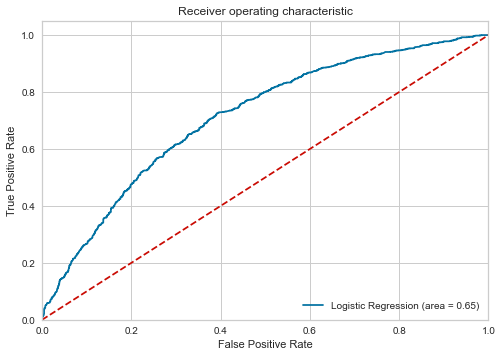

In [241]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(Y_validation, logreg.predict(X_validation_new2))
fpr, tpr, thresholds = roc_curve(Y_validation, logreg.predict_proba(X_validation_new2)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [242]:
train_df_n = train_df[['coupon', 'CoffeeHouse', 'destination', 'expiration', 'Restaurant20To50', 'weather', 'gender', 'passanger', 'Bar','direction_same','occupation','toCoupon_GEQ25min','Y']] 
validation_df_n = validation_df[['coupon', 'CoffeeHouse', 'destination', 'expiration', 'Restaurant20To50', 'weather', 'gender', 'passanger', 'Bar','direction_same','occupation','toCoupon_GEQ25min', 'Y']] 
test_df_n = test_df[['coupon', 'CoffeeHouse', 'destination', 'expiration', 'Restaurant20To50', 'weather', 'gender', 'passanger', 'Bar','direction_same','occupation','toCoupon_GEQ25min', 'Y']] 

### PyCaret model and comparison with base model 
It is a Python open source machine learning library designed to make performing standard tasks in a machine learning project easy.

It is a Python version of the Caret machine learning package in R, popular because it allows models to be evaluated, compared, and tuned on a given dataset with just a few lines of code.

In [243]:
# Importing module and initializing setup
from pycaret.classification import *
clf1 = setup(data = train_df_n, target = 'Y', test_data= validation_df_n, preprocess=False)

,Description,Value
0,session_id,354
1,Target,Y
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(6215, 13)"
5,Missing Values,False
6,Numeric Features,0
7,Categorical Features,12
8,Transformed Train Set,"(6215, 12)"
9,Transformed Test Set,"(2664, 12)"


In [244]:
best_model = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.6766,0.7257,0.7925,0.6854,0.7349,0.3257,0.3316,0.2130
lr,Logistic Regression,0.6578,0.7000,0.7666,0.6740,0.7171,0.2884,0.2926,4.3920
ridge,Ridge Classifier,0.6566,0.0000,0.7663,0.6729,0.7164,0.2859,0.2901,0.0380
lda,Linear Discriminant Analysis,0.6563,0.7002,0.7652,0.6729,0.7159,0.2854,0.2895,0.0420
ada,Ada Boost Classifier,0.6537,0.6986,0.7623,0.6710,0.7136,0.2802,0.2842,0.8970
qda,Quadratic Discriminant Analysis,0.6504,0.6923,0.7345,0.6759,0.7039,0.2788,0.2804,0.0420
rf,Random Forest Classifier,0.6467,0.6831,0.7089,0.6803,0.6941,0.2762,0.2768,0.4610
nb,Naive Bayes,0.6359,0.6671,0.7385,0.6594,0.6965,0.2450,0.2477,0.0360
et,Extra Trees Classifier,0.6315,0.6628,0.6595,0.6798,0.6694,0.2535,0.2537,0.4500
knn,K Neighbors Classifier,0.6299,0.6598,0.7121,0.6607,0.6852,0.2377,0.2389,0.1620


In [245]:
gbc_classifier = create_model('gbc')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.6945,0.7409,0.8210,0.6947,0.7526,0.3606,0.3693
1,0.6640,0.7101,0.7812,0.6757,0.7246,0.2995,0.3047
2,0.6640,0.7298,0.8011,0.6698,0.7296,0.2951,0.3034
3,0.7010,0.7426,0.8295,0.6986,0.7584,0.3735,0.3831
4,0.6752,0.7176,0.8125,0.6777,0.7390,0.3184,0.3277
5,0.6747,0.7133,0.7841,0.6866,0.7321,0.3228,0.3274
6,0.6779,0.7336,0.7841,0.6900,0.7340,0.3301,0.3344
7,0.6989,0.7396,0.7898,0.7110,0.7483,0.3761,0.3794
8,0.6570,0.7140,0.7550,0.6760,0.7133,0.2897,0.2924
9,0.6586,0.7156,0.7664,0.6742,0.7173,0.2909,0.2947


Checking Pycaret results on unprocessed data so as to find out the scope of improvement

In [246]:
train_df_wo_encoding1 = train_df_wo_encoding[['coupon', 'CoffeeHouse', 'destination', 'expiration', 'Restaurant20To50', 'weather', 'gender', 'passanger', 'Bar','direction_same','occupation','toCoupon_GEQ25min','Y']] 
validation_df_wo_encoding1= validation_df_wo_encoding[['coupon', 'CoffeeHouse', 'destination', 'expiration', 'Restaurant20To50', 'weather', 'gender', 'passanger', 'Bar','direction_same','occupation','toCoupon_GEQ25min','Y']] 
clf2 = setup(data = train_df_wo_encoding1, target = 'Y', test_data= validation_df_wo_encoding1, preprocess=True, fix_imbalance=True)

,Description,Value
0,session_id,2767
1,Target,Y
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(6215, 13)"
5,Missing Values,False
6,Numeric Features,0
7,Categorical Features,12
8,Ordinal Features,False
9,High Cardinality Features,False


In [247]:
best_model2 = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.6766,0.7279,0.7521,0.6994,0.7247,0.3340,0.3356,0.1930
gbc,Gradient Boosting Classifier,0.6719,0.7248,0.7331,0.7011,0.7166,0.3275,0.3282,0.4160
ridge,Ridge Classifier,0.6465,0.0000,0.6523,0.7023,0.6762,0.2881,0.2892,0.2160
lda,Linear Discriminant Analysis,0.6462,0.6984,0.6523,0.7019,0.6760,0.2874,0.2885,0.1380
lr,Logistic Regression,0.6459,0.6984,0.6504,0.7023,0.6752,0.2871,0.2883,0.1520
ada,Ada Boost Classifier,0.6444,0.6971,0.6686,0.6929,0.6803,0.2799,0.2803,0.2400
svm,SVM - Linear Kernel,0.6430,0.0000,0.6876,0.6882,0.6836,0.2721,0.2764,0.2180
rf,Random Forest Classifier,0.6412,0.6816,0.6947,0.6790,0.6865,0.2671,0.2675,0.7160
et,Extra Trees Classifier,0.6273,0.6615,0.6472,0.6791,0.6627,0.2470,0.2474,0.6260
knn,K Neighbors Classifier,0.6253,0.6567,0.6598,0.6720,0.6655,0.2395,0.2397,0.2630


####  Modelling using LGBM as given by Pycaret model as the best model


In [248]:
lgbm1 = create_model('lightgbm')
pred_holdout = predict_model(lgbm1)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.6865,0.7365,0.7585,0.7082,0.7325,0.3549,0.3562
1,0.6785,0.7287,0.7557,0.7000,0.7268,0.3375,0.3390
2,0.6736,0.7377,0.7841,0.6849,0.7311,0.3208,0.3256
3,0.7074,0.7646,0.7869,0.7214,0.7527,0.3961,0.3984
4,0.6720,0.7149,0.7614,0.6907,0.7243,0.3219,0.3242
5,0.6490,0.6968,0.7188,0.6801,0.6989,0.2788,0.2794
6,0.6763,0.7438,0.7500,0.7003,0.7243,0.3336,0.3347
7,0.6876,0.7116,0.7386,0.7182,0.7283,0.3610,0.3612
8,0.6651,0.7250,0.7322,0.6927,0.7119,0.3126,0.3133
9,0.6699,0.7189,0.7350,0.6973,0.7157,0.3228,0.3235


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.6821,0.7301,0.7726,0.7073,0.7385,0.3351,0.3372


In [249]:
# import math
# print(-(3/5)*math.log((3/5),2)-(2/5)*math.log((2/5),2))
# print(-(2/3)*math.log((2/3),2)-(1/3)*math.log((1/3),2))

In [250]:
# sm = SMOTE(random_state=42)
# X_train_noscore, y_train_noscore = sm.fit_resample(X_train_noscore, y_train_noscore)
# y_train_noscore.value_counts()
# # specify configurations as dict
# params = {
#     'boosting_type': 'gbdt',
#     'objective': 'binary',
#     'metric': 'binary_logloss',
#     'num_boost_round':1000,
#     'num_threads':2,
#     'num_class' : 1,
#     'max_bin':200,
#     'num_leaves': 32,
#     'max_depth' : -1,
#     'learning_rate': 0.02,
#     'num_class:':1,
#     }
# gbm = lgbm.LGBMClassifier(params)
# gridParams = {
#     'boosting_type':['dart','gbdt'],
#     'metric':[
#         'binary_logloss',
#         'binary_error',
#         'auc'
#     ],
#     'num_leaves': np.array([8,16,32]),
#     'max_bin':[50,100,200,500],
#     'objective':['binary']
# #     ,'feature_fraction': [0.2, 0.4, 0.6, 0.7, 0.8]
#      ,'reg_lambda': [0.01,10.0]
#      ,'min_data_in_leaf':[0,20]
# }

# grid = GridSearchCV(gbm, gridParams, verbose=2, cv=4, n_jobs=2)
# grid.fit(train_noscore.drop(columns=['active_status']),train_noscore['active_status'])
# run.log_list('grid.best_params_',grid.best_params_)
# run.log('grid.best_score_',grid.best_score_)
# best_params = grid.best_params_
# for i in best_params:
#     print(i)
# lgb_train = lgbm.Dataset(X_train_noscore, y_train_noscore)
# lgb_eval  = lgbm.Dataset(X_test_noscore, y_test_noscore, reference=lgb_train)
# gbm = lgbm.train(best_params,
#             lgb_train,
#             num_boost_round=5000,
#             valid_sets=[lgb_train,lgb_eval],
#             valid_names=['train', 'eval'],
#             learning_rates= lambda iter: 0.008 * (0.99 ** iter),  ## change from 0
#             early_stopping_rounds=10
#                 )
# # -

# gbm.save_model(models +'full_lgbm_opr_no_score_'+'.pkl')
# model = Model.register(model_path=models +'full_lgbm_opr_no_score_'+'.pkl',
#                        model_name="full_lgbm_opr_no_score_2021",
#                        workspace=ws)

#### Using SMOTE for unbalanced data

In [251]:
# if the dataset is unbalanced i.e no. of values in each level of target variable varies a lot.Then it should be balanced. 
# For this SMOTE is used.
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X_train_sm, y_train_sm= sm.fit_resample(Xtrain_new2, Ytrain)
y_train_sm.value_counts()

1    3518
0    3518
Name: Y, dtype: int64

In [252]:
#Now LGBM model is used to train data. For this parameters are provided for LGBMClassifier function.
import lightgbm as lgbm
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'binary_logloss',
    'num_boost_round':1000,
    'num_threads':2,
    'num_leaves': 32,
    'max_depth' : -1,
    'learning_rate': 0.05,
    'num_class:':1,
    }
gbm = lgbm.LGBMClassifier(params)

In [253]:
# Before training data, Best parameters are found out using GridSearchCV from all alternatives of parameters.
from sklearn.model_selection import GridSearchCV
import lightgbm as lgbm
gbm1 = lgbm.LGBMClassifier({
    'early_stopping_rounds':100, 'bagging_fraction': 0.5, 'bagging_freq' :5,  'objective':'binary',   'num_boost_round':1000,'num_threads':4,
})
gridParams = {
    'boosting_type':['dart','gbdt'],
    'metric':[
        'binary_logloss',
        'binary_error',
        'auc'
    ],
    'num_leaves': np.array([8,16,32]),
    'learning_rate': [0.05,0.1,0.15, 0.2, 0.25] ,
    'max_depth' : [2,3,4,5] 
}
grid = GridSearchCV(gbm1, gridParams, verbose=2, cv=4, n_jobs=1)
grid.fit(X_train_sm, y_train_sm)

Fitting 4 folds for each of 360 candidates, totalling 1440 fits
[CV] boosting_type=dart, learning_rate=0.05, max_depth=2, metric=binary_logloss, num_leaves=8 
[CV]  boosting_type=dart, learning_rate=0.05, max_depth=2, metric=binary_logloss, num_leaves=8, total=   0.1s
[CV] boosting_type=dart, learning_rate=0.05, max_depth=2, metric=binary_logloss, num_leaves=8 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV]  boosting_type=dart, learning_rate=0.05, max_depth=2, metric=binary_logloss, num_leaves=8, total=   0.1s
[CV] boosting_type=dart, learning_rate=0.05, max_depth=2, metric=binary_logloss, num_leaves=8 
[CV]  boosting_type=dart, learning_rate=0.05, max_depth=2, metric=binary_logloss, num_leaves=8, total=   0.1s
[CV] boosting_type=dart, learning_rate=0.05, max_depth=2, metric=binary_logloss, num_leaves=8 
[CV]  boosting_type=dart, learning_rate=0.05, max_depth=2, metric=binary_logloss, num_leaves=8, total=   0.1s
[CV] boosting_type=dart, learning_rate=0.05, max_depth=2, metric=binary_logloss, num_leaves=16 
[CV]  boosting_type=dart, learning_rate=0.05, max_depth=2, metric=binary_logloss, num_leaves=16, total=   0.1s
[CV] boosting_type=dart, learning_rate=0.05, max_depth=2, metric=binary_logloss, num_leaves=16 
[CV]  boosting_type=dart, learning_rate=0.05, max_depth=2, metric=binary_logloss, num_leaves=16, total=   0.1s
[CV] boosting_type=dart, learning_rate=0.05, max_depth=2, metric=b

[Parallel(n_jobs=1)]: Done 1440 out of 1440 | elapsed:  2.5min finished


GridSearchCV(cv=4, error_score=nan,
             estimator=LGBMClassifier(boosting_type={'bagging_fraction': 0.5,
                                                     'bagging_freq': 5,
                                                     'early_stopping_rounds': 100,
                                                     'num_boost_round': 1000,
                                                     'num_threads': 4,
                                                     'objective': 'binary'},
                                      class_weight=None, colsample_bytree=1.0,
                                      importance_type='split',
                                      learning_rate=0.1, max_depth=-1,
                                      min_child_samples=20,
                                      min_child_weight=0.001,
                                      min_split...
                                      subsample=1.0, subsample_for_bin=200000,
                                      su

In [254]:
#Finding best parameters
best_params = grid.best_params_
print(best_params)


{'boosting_type': 'gbdt', 'learning_rate': 0.25, 'max_depth': 5, 'metric': 'binary_logloss', 'num_leaves': 32}


In [255]:
#Using LGBM Classifier with best parameters and then training the training data
gbm = lgbm.LGBMClassifier(objective='binary',   
                        num_boost_round= 1000,
                        num_threads= 4,
                        boosting_type= 'gbdt', 
                        learning_rate= 0.25, 
                        max_depth= 5, 
                        metric= 'binary_logloss')
gbm.fit(X_train_sm, y_train_sm,
        early_stopping_rounds= 100,
        eval_set=[(X_train_sm, y_train_sm), (X_validation_new2, Y_validation)])


[1]	training's binary_logloss: 0.656072	valid_1's binary_logloss: 0.66159
[2]	training's binary_logloss: 0.633366	valid_1's binary_logloss: 0.643523
[3]	training's binary_logloss: 0.618392	valid_1's binary_logloss: 0.631835
[4]	training's binary_logloss: 0.608625	valid_1's binary_logloss: 0.625181
[5]	training's binary_logloss: 0.600986	valid_1's binary_logloss: 0.621846
[6]	training's binary_logloss: 0.59493	valid_1's binary_logloss: 0.617414
[7]	training's binary_logloss: 0.590163	valid_1's binary_logloss: 0.614986
[8]	training's binary_logloss: 0.585279	valid_1's binary_logloss: 0.612439
[9]	training's binary_logloss: 0.581421	valid_1's binary_logloss: 0.61033
[10]	training's binary_logloss: 0.578076	valid_1's binary_logloss: 0.609274
[11]	training's binary_logloss: 0.575219	valid_1's binary_logloss: 0.608132
[12]	training's binary_logloss: 0.572829	valid_1's binary_logloss: 0.60686
[13]	training's binary_logloss: 0.570054	valid_1's binary_logloss: 0.604924
[14]	training's binary_lo

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.25, max_depth=5,
               metric='binary_logloss', min_child_samples=20,
               min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
               n_jobs=-1, num_boost_round=1000, num_leaves=31, num_threads=4,
               objective='binary', random_state=None, reg_alpha=0.0,
               reg_lambda=0.0, silent='warn', subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

In [256]:
#Predictions using trained data on validation data and output as 1 and 0 is available
y_pred = gbm.predict(X_validation_new2)

In [257]:
#If output is needed in terms of probability
gbm.predict_proba(X_validation_new2)

array([[0.83605346, 0.16394654],
       [0.2283968 , 0.7716032 ],
       [0.38406968, 0.61593032],
       ...,
       [0.32329973, 0.67670027],
       [0.73605568, 0.26394432],
       [0.35270949, 0.64729051]])

In [258]:
from sklearn.model_selection import cross_val_score
print('Accuracy for Train Set', cross_val_score(gbm, Xtrain_new2, Ytrain, scoring='accuracy', cv=4, n_jobs=4))
print('Accuracy for Validation Set', cross_val_score(gbm, X_validation_new2, Y_validation, scoring='accuracy', cv=4, n_jobs=4))

Accuracy for Train Set [0.65186615 0.65250965 0.65637066 0.6394076 ]
Accuracy for Validation Set [0.62912913 0.63363363 0.62012012 0.61561562]


In [259]:
print('auc for Train Set', cross_val_score(gbm, Xtrain_new2, Ytrain, scoring='roc_auc', cv=4, n_jobs=4))
print('auc for Validation Set', cross_val_score(gbm, X_validation_new2, Y_validation, scoring='roc_auc', cv=4, n_jobs=4))

auc for Train Set [0.69912075 0.68847704 0.67592466 0.68130851]
auc for Validation Set [0.66581923 0.66670371 0.65199633 0.65501561]


In [260]:
cross_val_score(gbm, X_validation_new2, Y_validation, scoring='accuracy', cv=4, n_jobs=-1)

array([0.62912913, 0.63363363, 0.62012012, 0.61561562])

In [261]:
# lgb_train = lgbm.Dataset(X_train_sm, y_train_sm)
# lgb_eval  = lgbm.Dataset(X_validation_new2, Y_validation, reference=lgb_train)
# gbm = lgbm.train(best_params,
            
#             lgb_train,
#             num_boost_round=5000,
#             valid_sets=[lgb_train,lgb_eval],
#             valid_names=['train', 'eval'],
#             early_stopping_rounds=10,
#                 )

In [262]:
y_pred = gbm.predict(X_validation_new2, raw_score=False)
print(y_pred)

[0 1 1 ... 1 0 1]


### Finding Threshold using roc-auc

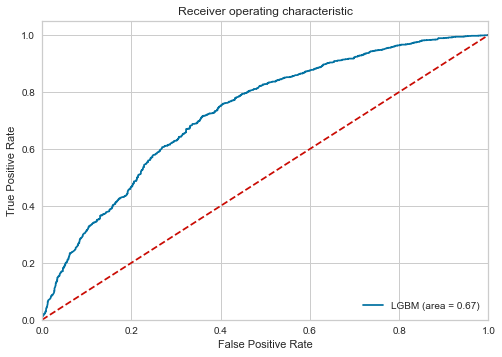

In [263]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(Y_validation, y_pred)
fpr, tpr, thresholds = roc_curve(Y_validation, gbm.predict_proba(X_validation_new2)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='LGBM (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [264]:
# search thresholds for imbalanced classification
from numpy import arange
from numpy import argmax
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

# apply threshold to positive probabilities to create labels
def to_labels(pos_probs, threshold):
	return (pos_probs >= threshold).astype('int')

yhat = gbm.predict_proba(Xtrain_new2)
# keep probabilities for the positive outcome only
probs = yhat[:, 1]
# define thresholds
thresholds = arange(0, 1, 0.001)
# evaluate each threshold
scores = [f1_score(Ytrain, to_labels(probs, t)) for t in thresholds]
# get best threshold
ix = argmax(scores)
print('Threshold=%.3f, F-Score=%.5f' % (thresholds[ix], scores[ix]))

Threshold=0.316, F-Score=0.76853


In [265]:
# search thresholds for imbalanced classification
from numpy import arange
from numpy import argmax
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

# apply threshold to positive probabilities to create labels
def to_labels(pos_probs, threshold):
	return (pos_probs >= threshold).astype('int')


yhat = gbm.predict_proba(X_validation_new2)
# keep probabilities for the positive outcome only
probs = yhat[:, 1]
# define thresholds
thresholds = arange(0, 1, 0.001)
# evaluate each threshold
scores = [f1_score(Y_validation, to_labels(probs, t)) for t in thresholds]
# get best threshold
ix = argmax(scores)
print('Threshold=%.3f, F-Score=%.5f' % (thresholds[ix], scores[ix]))

Threshold=0.331, F-Score=0.76343


In [266]:
# search thresholds for imbalanced classification
from numpy import arange
from numpy import argmax
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

# apply threshold to positive probabilities to create labels
def to_labels(pos_probs, threshold):
	return (pos_probs >= threshold).astype('int')


# keep probabilities for the positive outcome only
yhat = gbm.predict_proba(Xtrain_new2)
probs_train = yhat[:, 1]
yhat = gbm.predict_proba(X_validation_new2)
probs_val = yhat[:, 1]
# define thresholds
thresholds = [0.3]
# evaluate each threshold
score_train = [f1_score(Ytrain, to_labels(probs_train, t)) for t in thresholds]
score_val = [f1_score(Y_validation, to_labels(probs_val, t)) for t in thresholds]
# get best threshold
ix = 0
print('Threshold_train=%.3f, F-Score_train=%.5f' % (thresholds[ix], score_train[ix]))
print('Threshold_test=%.3f, F-Score_test=%.5f' % (thresholds[ix], score_val[ix]))


Threshold_train=0.300, F-Score_train=0.76761
Threshold_test=0.300, F-Score_test=0.76018


In [267]:
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, roc_auc_score, precision_score

def MyLGBClassifier(gbm, X, Y, THRESHOLD):
    preds = np.where(gbm.predict_proba(X)[:,1] > THRESHOLD, 1, 0)
    df = pd.DataFrame(data=[accuracy_score(Y, preds), recall_score(Y, preds),
                   precision_score(Y, preds), roc_auc_score(Y, preds)], 
             index=["accuracy", "recall", "precision", "roc_auc_score"])
    return df


In [268]:
MyLGBClassifier(gbm, X_validation_new2, Y_validation, 0.3)

,0
accuracy,0.661787
recall,0.922481
precision,0.646446
roc_auc_score,0.611330


In [269]:
MyLGBClassifier(gbm, Xtrain_new2, Ytrain, 0.3)

,0
accuracy,0.676267
recall,0.944571
precision,0.646498
roc_auc_score,0.635430


In [270]:
MyLGBClassifier(gbm, Xtest_new2, Y_test, 0.3)

,0
accuracy,0.653351
recall,0.927705
precision,0.630828
roc_auc_score,0.613461


#### Using shap values to interpret the model
The SHAP summary plot tells us the most important features and their range of effects over the dataset.

In [271]:
import shap

explainer = shap.Explainer(gbm)
shap_values = explainer.shap_values(Xtrain_new2)

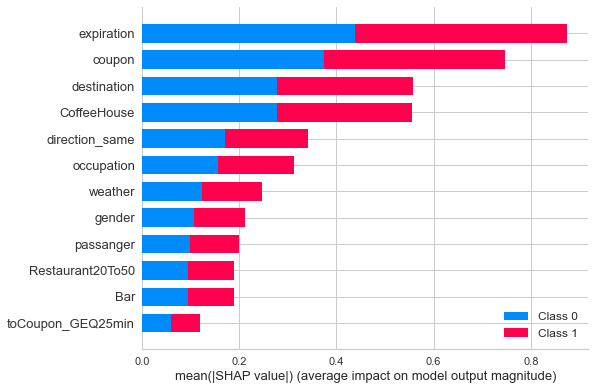

In [272]:
shap.summary_plot(shap_values, Xtrain_new2, plot_type="bar")

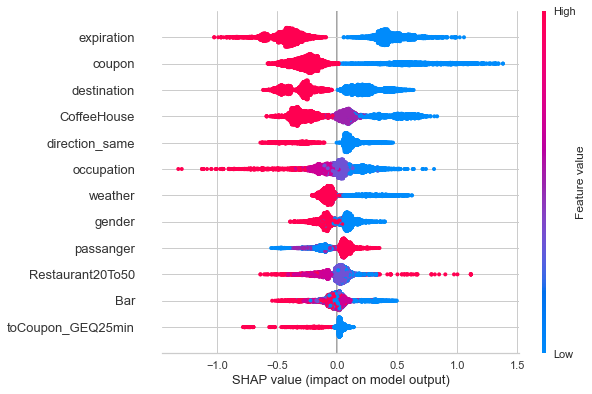

In [273]:
shap_values = explainer.shap_values(Xtrain_new2)
shap.summary_plot(shap_values[0], Xtrain_new2.values, feature_names = Xtrain_new2.columns)

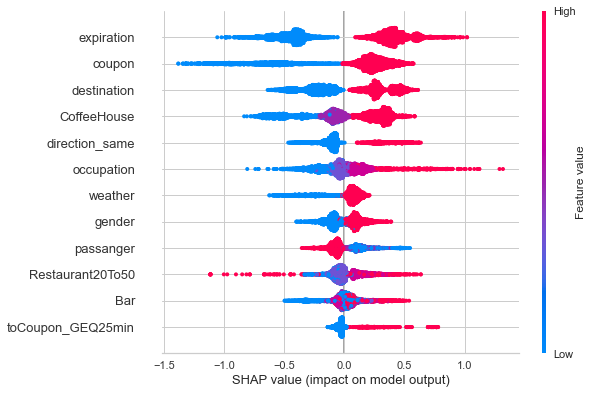

In [274]:
shap.summary_plot(shap_values[1], Xtrain_new2.values, feature_names = Xtrain_new2.columns)

Summary plot shows:
1. Expiration feature has the strongest effect on chances of acceptance. As expiration time increases, chances of acceptance increases.
2. People going to Coffee house, carry and takeaway and restaurants where average expense per month is less than $20 are more likely to accept coupon.
3. The people who had gone to coffeehouse atleast once have more chances of accepting the coupon.
4. The people who are not going to any urgent place have more chances of accepting the coupon.
5. The people who are travelling with their friend(s) are more likely to accept the coupon.
7. If restaurant/bar is in same direction in which the person is travelling, then he/she is more likely to accept the coupon.
8. If occupation is 'legal', the chances of accepting the coupon is least.
9. In Sunny weather, people are more likely to accept the coupon.
10. The person who has never gone to Bar, are least likely to accept the coupon.
11. Males are more likely to accept the coupon.
12. The people who go to restaurant very less or rarelyand have average expense is $20 to 50 have less chances of coupon acceptance.
13. For people having driving distance greater than 25 minutes it is less likely to accept the coupon. 

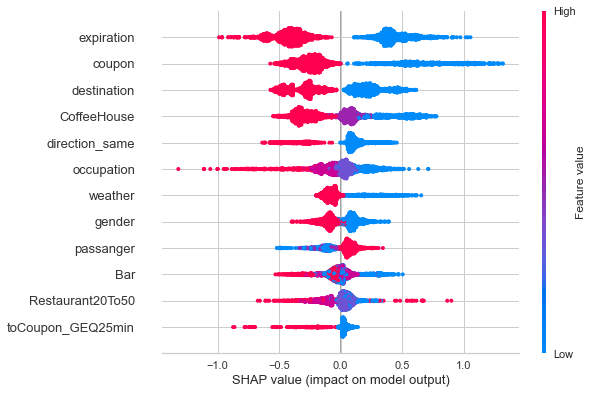

In [275]:
shap_values = explainer.shap_values(X_validation_new2)
shap.summary_plot(shap_values[0], X_validation_new2.values, feature_names = X_validation_new2.columns)

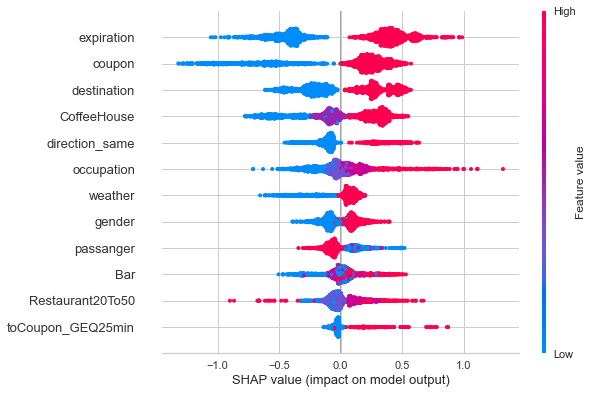

In [276]:
shap.summary_plot(shap_values[1], X_validation_new2.values, feature_names = X_validation_new2.columns)

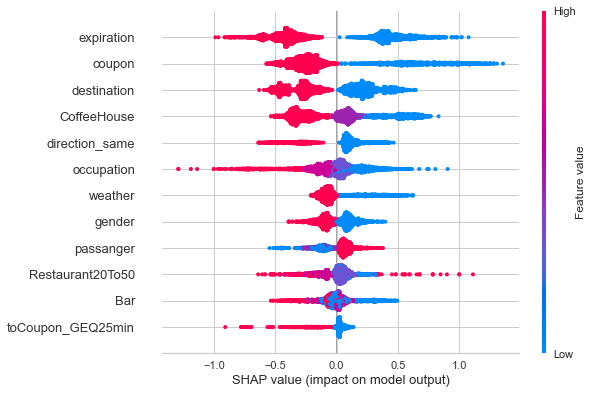

In [277]:
shap_valuesn = explainer.shap_values(Xtest_new2)
shap.summary_plot(shap_valuesn[0], Xtest_new2.values, feature_names = Xtest_new2.columns)

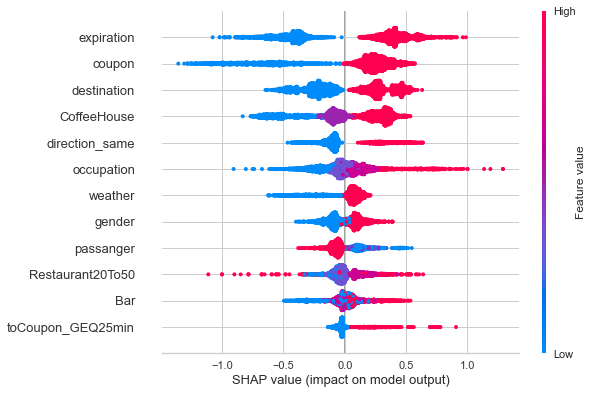

In [278]:
shap.summary_plot(shap_valuesn[1], Xtest_new2.values, feature_names = Xtest_new2.columns)